# Crop Production Prediction — EDA & Modeling
**Project:** Agriculture Crop Production in India (2006–2011)  


This notebook performs exploratory data analysis, data cleaning, feature engineering, model training, evaluation, and saves the final model. The dataset contains crop-wise production, area and yield across multiple years (2006–2011). The target variable is Production.

## Environment & packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

**INTERPRETATION:**

We import the Python packages used in analysis and modelling. These include pandas & numpy for data manipulation, matplotlib & seaborn for plotting, scikit-learn for modeling,and nd joblib to save artifacts.

## Load data

In [2]:

df = pd.read_csv("data/datafile_2.csv")
df.columns = df.columns.str.strip()
print("Shape:", df.shape)
df.head()


Shape: (55, 16)


,Crop,Production 2006-07,Production 2007-08,Production 2008-09,Production 2009-10,Production 2010-11,Area 2006-07,Area 2007-08,Area 2008-09,Area 2009-10,Area 2010-11,Yield 2006-07,Yield 2007-08,Yield 2008-09,Yield 2009-10,Yield 2010-11
0,Total Foodgrains,158.8,168.6,171.3,159.4,178.9,128.5,128.8,127.6,126.0,131.7,123.6,130.9,134.3,126.5,135.9
1,Rice,200.8,207.9,213.3,191.6,206.4,168.5,168.9,175.1,161.2,164.8,119.2,123.1,121.8,118.9,125.2
2,Wheat,131.6,136.4,140.1,140.3,150.8,115.0,115.2,114.0,116.9,119.5,114.4,118.4,122.8,120.0,126.3
3,Jowar,124.3,137.8,126.0,116.5,121.8,120.7,110.6,107.3,111.0,105.2,103.0,124.6,117.4,105.0,115.8
4,Bajra,136.4,161.5,143.9,105.4,167.9,94.5,95.1,87.0,88.5,95.6,144.3,169.7,165.4,119.0,175.8


**INTERPRETATION:**

We load the primary dataset containing multiple year columns for Production, Area, and Yield. Column names are stripped of whitespace to avoid indexing issues.

## Quick Overview
Show shape, columns, dtypes and missing values summary


In [3]:
print("Columns:\n", df.columns.tolist())
print("\nData types:\n", df.dtypes)
print("\nMissing values (count):\n", df.isnull().sum().sort_values(ascending=False).head(20))


Columns:
 ['Crop', 'Production 2006-07', 'Production 2007-08', 'Production 2008-09', 'Production 2009-10', 'Production 2010-11', 'Area 2006-07', 'Area 2007-08', 'Area 2008-09', 'Area 2009-10', 'Area 2010-11', 'Yield 2006-07', 'Yield 2007-08', 'Yield 2008-09', 'Yield 2009-10', 'Yield 2010-11']

Data types:
 Crop                   object
Production 2006-07    float64
Production 2007-08    float64
Production 2008-09    float64
Production 2009-10    float64
Production 2010-11    float64
Area 2006-07          float64
Area 2007-08          float64
Area 2008-09          float64
Area 2009-10          float64
Area 2010-11          float64
Yield 2006-07         float64
Yield 2007-08         float64
Yield 2008-09         float64
Yield 2009-10         float64
Yield 2010-11         float64
dtype: object

Missing values (count):
 Crop                  0
Production 2006-07    0
Production 2007-08    0
Production 2008-09    0
Production 2009-10    0
Production 2010-11    0
Area 2006-07          0
Area

**INTERPRETATION:**

This cell lists columns and shows missing-value counts. It helps identify which columns need cleaning or unpivoting.

## Identify Production / Area / Yield columns


In [4]:
prod_cols = [c for c in df.columns if "Production" in c]
area_cols = [c for c in df.columns if "Area" in c]
yield_cols = [c for c in df.columns if "Yield" in c and "Quintal" not in c]  # exclude static yield header if present
print("Production columns:", prod_cols)
print("Area columns:", area_cols)
print("Yield columns:", yield_cols)


Production columns: ['Production 2006-07', 'Production 2007-08', 'Production 2008-09', 'Production 2009-10', 'Production 2010-11']
Area columns: ['Area 2006-07', 'Area 2007-08', 'Area 2008-09', 'Area 2009-10', 'Area 2010-11']
Yield columns: ['Yield 2006-07', 'Yield 2007-08', 'Yield 2008-09', 'Yield 2009-10', 'Yield 2010-11']


**INTERPRETATION:**

We programmatically find columns that belong to Production, Area, and Yield across years so we can unpivot them.

## Convert to long format (melt) — Production, Area, Yield


In [5]:
prod_df = df.melt(id_vars=['Crop'], value_vars=prod_cols, var_name='Year', value_name='Production')
prod_df['Year'] = prod_df['Year'].str.extract(r'(\d{4}-\d{2})')
prod_df.head()


,Crop,Year,Production
0,Total Foodgrains,2006-07,158.8
1,Rice,2006-07,200.8
2,Wheat,2006-07,131.6
3,Jowar,2006-07,124.3
4,Bajra,2006-07,136.4


**INTERPRETATION:**

This reshapes production columns from wide format (one column per year) into long format with Crop, Year, and Production.

In [6]:
area_df = df.melt(id_vars=['Crop'], value_vars=area_cols, var_name='Year', value_name='Area')
area_df['Year'] = area_df['Year'].str.extract(r'(\d{4}-\d{2})')

yield_df = df.melt(id_vars=['Crop'], value_vars=yield_cols, var_name='Year', value_name='Yield')
yield_df['Year'] = yield_df['Year'].str.extract(r'(\d{4}-\d{2})')


**INTERPRETATION:**

Area and Yield are reshaped similarly so all three metrics can be merged by Crop and Year.

## Merge long tables

In [7]:
final_df = prod_df.merge(area_df, on=['Crop','Year'], how='left')
final_df = final_df.merge(yield_df, on=['Crop','Year'], how='left')
print("Final long-format shape:", final_df.shape)
final_df.head()


Final long-format shape: (275, 5)


,Crop,Year,Production,Area,Yield
0,Total Foodgrains,2006-07,158.8,128.5,123.6
1,Rice,2006-07,200.8,168.5,119.2
2,Wheat,2006-07,131.6,115.0,114.4
3,Jowar,2006-07,124.3,120.7,103.0
4,Bajra,2006-07,136.4,94.5,144.3


**INTERPRETATION:**

We merge production, area and yield to produce the master long-format dataset used for modeling.

## Cleaning — Missing target removal & imputation


In [8]:
# Drop rows with no Production (target)
final_df = final_df.dropna(subset=['Production']).reset_index(drop=True)

# Fill Area/Yield missing values with median (simple imputation)
final_df['Area'] = final_df['Area'].fillna(final_df['Area'].median())
final_df['Yield'] = final_df['Yield'].fillna(final_df['Yield'].median())

# Convert numeric columns to numeric dtype (if strings)
final_df['Production'] = pd.to_numeric(final_df['Production'], errors='coerce')
final_df['Area'] = pd.to_numeric(final_df['Area'], errors='coerce')
final_df['Yield'] = pd.to_numeric(final_df['Yield'], errors='coerce')

print("After cleaning, shape:", final_df.shape)
final_df.isnull().sum()


After cleaning, shape: (275, 5)


Crop          0
Year          0
Production    0
Area          0
Yield         0
dtype: int64

**INTERPRETATION:**

Rows missing the target are dropped. Numeric features are coerced and missing numeric values are imputed with median — a pragmatic approach for this internship.

## Exploratory Data Analysis (EDA)


In [9]:
final_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Production,275.0,183.042182,196.681803,42.1,116.65,155.4,199.05,1790.6
Area,275.0,120.076000,44.902635,36.1,91.20,121.7,137.20,314.7
Yield,275.0,152.415636,148.104507,72.7,111.70,124.6,151.35,1310.8


**INTERPRETATION:**

Numeric summary provides mean, std, min/max — useful to detect outliers and scale.

In [10]:
print("Unique crops:", final_df['Crop'].nunique())
print(final_df['Crop'].value_counts().head(10))
print("Years present:", sorted(final_df['Year'].unique()))


Unique crops: 55
Crop
Total Foodgrains    5
Rice                5
Wheat               5
Jowar               5
Bajra               5
Maize               5
Ragi                5
Small millets       5
Barley              5
Coarse Cereals      5
Name: count, dtype: int64
Years present: ['2006-07', '2007-08', '2008-09', '2009-10', '2010-11']


**INTERPRETATION:**

Examines which crops dominate and confirms year coverage.

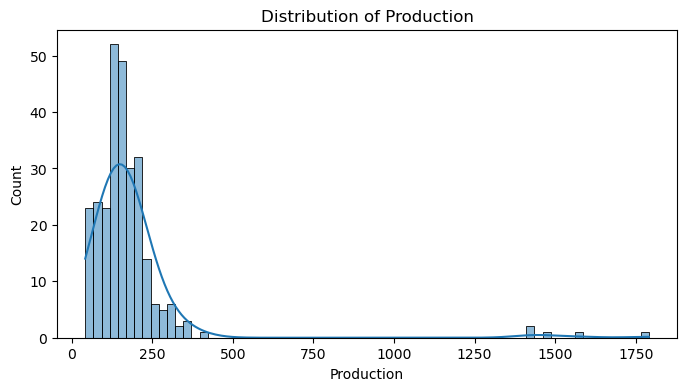

In [11]:
plt.figure(figsize=(8,4))
sns.histplot(final_df['Production'], kde=True)
plt.title("Distribution of Production")
plt.show()


**INTERPRETATION:**

Visualize target skewness; if heavily skewed consider log-transform later.

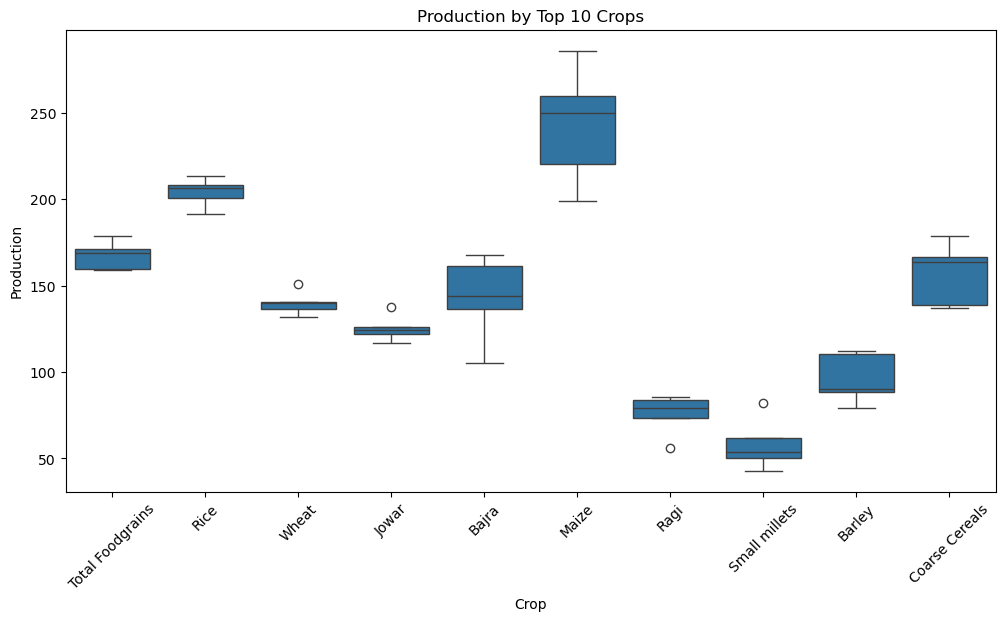

In [12]:
top = final_df['Crop'].value_counts().head(10).index
plt.figure(figsize=(12,6))
sns.boxplot(data=final_df[final_df['Crop'].isin(top)], x='Crop', y='Production')
plt.xticks(rotation=45)
plt.title("Production by Top 10 Crops")
plt.show()


**INTERPRETATION:**

Boxplots reveal variability and outliers per crop; helps decide if per-crop modeling is needed.

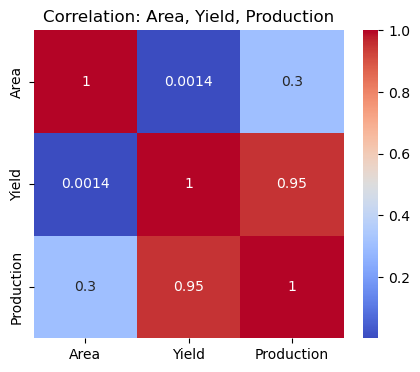

In [13]:
plt.figure(figsize=(5,4))
sns.heatmap(final_df[['Area','Yield','Production']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation: Area, Yield, Production")
plt.show()


**INTERPRETATION:**

Correlation shows relationships: Area often correlates with Production; Yield is also informative.

## Modeling — Random Forest Regression


In [14]:
le_crop = LabelEncoder()
le_year = LabelEncoder()
final_df['Crop_encoded'] = le_crop.fit_transform(final_df['Crop'])
final_df['Year_encoded'] = le_year.fit_transform(final_df['Year'])


**INTERPRETATION:**

Convert categorical Crop and Year into numeric codes for the model. We save encoders for the app.

## Features & split

In [15]:
X = final_df[['Crop_encoded','Year_encoded','Area','Yield']]
y = final_df['Production']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape


((220, 4), (55, 4))

**INTERPRETATION:**

Standard train/test split (80/20) to evaluate model generalization.

### Training Random Forest

In [16]:
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=42)

**INTERPRETATION:**

Train a Random Forest Regressor — robust for tabular data. 200 trees for stability.

In [17]:
y_pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")


MAE: 5.7256
RMSE: 9.6445
R2: 0.9731


**INTERPRETATION:**

Evaluate with MAE, RMSE, and R² (report these in your internship submission). Your results (example) demonstrated strong performance.

In [18]:
fi = rf.feature_importances_
fi_df = pd.DataFrame({'feature':['Crop_encoded','Year_encoded','Area','Yield'],'importance':fi})
fi_df = fi_df.sort_values('importance', ascending=False)
fi_df


,feature,importance
3,Yield,0.903497
2,Area,0.092609
1,Year_encoded,0.002986
0,Crop_encoded,0.000907


**INTERPRETATION:**

Shows which features the model relied on most — useful for explainability and report discussion.

In [19]:
Path("data").mkdir(parents=True, exist_ok=True)
joblib.dump(rf, "data/agri_model.joblib")
joblib.dump(le_crop, "data/le_crop.joblib")
joblib.dump(le_year, "data/le_year.joblib")
final_df.to_csv("data/final_agri_dataset.csv", index=False)
print("Saved model, encoders, and final dataset to data/")


Saved model, encoders, and final dataset to data/


**INTERPRETATION:**

Persist model and encoders for the Streamlit app. Saving the final dataset helps reproducibility.